<a href="https://colab.research.google.com/github/Wardmisp/Bird-Eye-View/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
from torchsummary import summary
import pandas as pd


Solve the padding = 'same' issue

In [4]:
def padding_same(output_dim,input_dim, kernel, stride):
  return (int((output_dim-((input_dim-kernel)/stride+1))*stride/2))

# Define Unet

In [18]:
class Net(torch.nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        # 1
        self.cnn_layers1 = torch.nn.Sequential(
            torch.nn.Conv2d(7, 64, kernel_size=8, stride=2, padding=[padding_same(48,96,8,2),padding_same(72,144,8,2)]),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        # 2
        self.cnn_layers2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=6, stride=2, padding=[padding_same(24,48,6,2),padding_same(36,72,6,2)]),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        # 3
        self.cnn_layers3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=[padding_same(12,24,4,2),padding_same(18,36,4,2)]),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(256, 128, kernel_size=6, stride=2, padding=[20,14]),
            torch.nn.BatchNorm2d(128))
        
        # 4
        self.cnn_layers4 = torch.nn.Sequential(
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(256, 64, kernel_size=6, stride=2, padding=[38,26]),
            torch.nn.BatchNorm2d(64))
        
        #5
        self.cnn_layers5 = torch.nn.Sequential(
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(128, 7, kernel_size=8, stride=2, padding=1), ##WOOOPS LE PADDING
            torch.nn.Softmax())

    # Defining the forward pass concat here
    def forward(self, x):
        x = self.cnn_layers1(x)
        y = self.cnn_layers2(x)
        z = self.cnn_layers3(y)
        y = torch.cat((y,z),-3)
        y = self.cnn_layers4(y)
        x = torch.cat((x,y),-3)
        x = self.cnn_layers5(x)
        return x

# defining the model
model = Net()    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()
summary(model,(7, 144, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 72, 48]          28,736
         LeakyReLU-2           [-1, 64, 72, 48]               0
            Conv2d-3          [-1, 128, 36, 24]         295,040
       BatchNorm2d-4          [-1, 128, 36, 24]             256
         LeakyReLU-5          [-1, 128, 36, 24]               0
            Conv2d-6          [-1, 256, 18, 12]         524,544
       BatchNorm2d-7          [-1, 256, 18, 12]             512
         LeakyReLU-8          [-1, 256, 18, 12]               0
          Upsample-9          [-1, 256, 36, 24]               0
           Conv2d-10          [-1, 128, 36, 24]       1,179,776
      BatchNorm2d-11          [-1, 128, 36, 24]             256
        LeakyReLU-12          [-1, 256, 36, 24]               0
         Upsample-13          [-1, 256, 72, 48]               0
           Conv2d-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Import Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
Download = True #@param {type:"boolean"}

if Download:
  !gdown "https://drive.google.com/uc?id=1x0JdeA2Mo_QvYIJDHMfempoy2R675gMi" -O "birds_eye_data.zip"

!unzip 'birds_eye_data.zip' 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/right/40170.npy    
  inflating: data/right/32064.npy    
  inflating: data/right/36996.npy    
  inflating: data/right/36932.npy    
  inflating: data/right/20050.npy    
  inflating: data/right/15450.npy    
  inflating: data/right/22703.npy    
  inflating: data/right/11843.npy    
  inflating: data/right/24417.npy    
  inflating: data/right/26061.npy    
  inflating: data/right/41115.npy    
  inflating: data/right/32412.npy    
  inflating: data/right/428.npy      
  inflating: data/right/8140.npy     
  inflating: data/right/20966.npy    
  inflating: data/right/30368.npy    
  inflating: data/right/45622.npy    
  inflating: data/right/4634.npy     
  inflating: data/right/16072.npy    
  inflating: data/right/40601.npy    
  inflating: data/right/18667.npy    
  inflating: data/right/44578.npy    
  inflating: data/right/45098.npy    
  inflating: data/right/5655.npy     
  inflatin

On charge les données et on affiche les images


In [8]:
import matplotlib.pyplot as plt
import numpy as np


def plot_cameras(sequence_number):

  rows = 2
  columns = 3
  fig=plt.figure(figsize=(10, 10))
  imgs = []
  cameras = ['left', 'front','right', 'back','top']
  
  for i, camera in enumerate(cameras):
    sample = np.load(f"./data/{camera}/{sequence_number}.npy")
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(sample, cmap='gist_stern')
  plt.show()

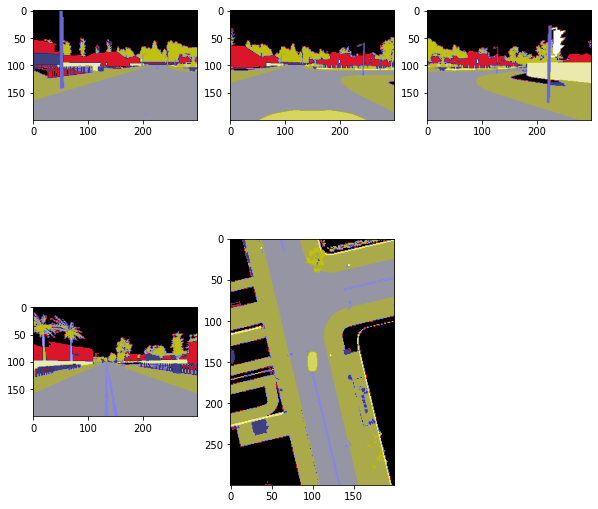

In [9]:
plot_cameras(100)

# Data Generator

In [10]:
import os

def get_paths(val_size=5000):

  img_paths = []

  for i in range(len(os.listdir('./data/top'))):
    path = f'{i}.npy'
    img_paths.append(path)

  return pd.DataFrame({'path':img_paths[:-val_size]}), pd.DataFrame({'path':img_paths[-val_size:]})

In [11]:
img_paths_train, img_paths_val = get_paths()
img_paths_train

,path
0,0.npy
1,1.npy
2,2.npy
3,3.npy
4,4.npy
...,...
40995,40995.npy
40996,40996.npy
40997,40997.npy
40998,40998.npy


In [12]:
def img_to_categorical(img, needed_labels):
  
  cat = np.empty((img.shape[0], img.shape[1], len(needed_labels)))

  for channel, label in enumerate(needed_labels):
    cat[:, :, channel] = np.where(np.isin(img, label), 1, 0)

  return cat

def categorical_to_img(cat):
  
  cat = np.argmax(cat, axis=-1)
  return cat

needed_labels = [0, 1, 6, 7, 8, 10, 11]

In [21]:
import random
import numpy as np
import cv2
import torch
import torchvision

# custom augmentation functions
#from image_augmentation import *

class PytorchDataGenerator(torch.utils.data.Dataset):
    def __init__(self, img_paths, base_path, to_fit=True, batch_size=32, shuffle=True, needed_classes = []):
    
        self.img_paths = img_paths.copy()
        self.base_path = base_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.needed_classes = needed_classes
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(len(self.img_paths) // self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        current_indexes = list(range(index * self.batch_size, (index + 1) * self.batch_size))
        img_paths_temp = self.img_paths[current_indexes]

        # Generate data
        X = self._generate_X(img_paths_temp)

        if self.to_fit:
            y = self._generate_y(img_paths_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            indices = np.arange(len(self.img_paths))
            np.random.shuffle(indices)
            self.img_paths = self.img_paths[indices]
            self.img_paths.reset_index(drop=True, inplace=True)


    def _generate_X(self, img_paths_temp):
        """Generates data containing batch_size images
        :param img_paths_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization

        X = []

        # Generate data
        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path)
            img = torch.tensor(img).float().unsqueeze(0).permute(0,3,2,1).to(device)
            X.append(img)

        return X

    def _generate_y(self, img_paths_temp):

        y = []

        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path, front=False)
            img = torch.tensor(img).float().unsqueeze(0).permute(0,3,2,1).to(device)
            y.append(img) 
        return y

    def _load_image(self, image_path, front=True):
      
        if front:
          img_dir =  '/front/'
        else:
          img_dir =  '/top/'

        img = np.load(self.base_path + img_dir + image_path)
        img = img[::2, ::2]                                          # Downsampling image by factor of 2

        if not front:
          img = img[3:(img.shape[0]//2)]
          img = np.rot90(img)
          img = img[2:-2]                                           # Crop Image to make dimensions divisible by 8 
          img = img_to_categorical(img, self.needed_classes)

          return img
          
        img = img[2:-2, 3:-3]                                       # Crop Image to make dimensions divisible by 8 
        img = img_to_categorical(img, self.needed_classes)

        return img

        

Entrer une image dans le reseau

torch.Size([1, 7, 144, 96])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


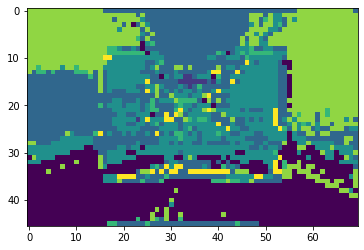

In [25]:
train_generator = PytorchDataGenerator(img_paths_train['path'], './data', batch_size=32, shuffle=True, needed_classes=needed_labels)
X, y = train_generator.__getitem__(0)
print(X[0].shape)
ouput=model(X[0])

ouput_numpy = ouput.squeeze(0).permute(1,2,0).detach().cpu().numpy()
res = np.rot90(categorical_to_img(ouput_numpy), 3)
plt.imshow( res, vmin=0, vmax=len(needed_labels)-1)
plt.show()

In [16]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

checking if the model can run in live

> The model can process 220 input in less than a second



In [32]:
from time import time
fps = 220

x = np.random.random((1,7, 144, 96))
start = time()

for i in range(fps):
  out = model(torch.tensor(x).float().to(device))

print(time() - start)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9730427265167236
